## **BILLIONAIRES, WHO, WHERE, WHEN, and MORE**
#### **What the Forbes Billionaire Dataset can tell us about them.**

Every year Forbes releases a ranking of the wealthiest people on the planet. Besides the long list of rich people beyond imagination, the dataset includes a wide variety of relevant information, such as net wealth, residence, citizenship, age, source of wealth, marital status and education. This article aims to extrapolate some relevant insights from the mass of data and analyse how billionaires are distributed according to different metrics. Particular attention is dedicated to the comparison between the super-rich in the United States and China.

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forbes-billionaires-modified/forbes_billionaires_geo_3.csv
/kaggle/input/forbes-billionaires-2021-30/forbes_billionaires_geo.csv


Key libraries are imported or installed:

In [6]:
%%time
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
import missingno as msno
# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate                                                                                                                                                                                       
import warnings
warnings.filterwarnings("ignore")

!pip install --upgrade plotly==4.14.3
import plotly.express as px
import plotly.graph_objects as go
!pip install folium pandas
import folium

# Set Color Palettes for the notebook
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--"})
sns.despine(left=True, bottom=True)
mpl.rcParams['figure.dpi'] = 250
mpl.rc('axes', labelsize=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

CPU times: user 219 ms, sys: 64.1 ms, total: 283 ms
Wall time: 10.7 s


In [7]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

def Age(age):
    if age >= 90 : return '90 years old'
    if age >= 80 : return '80 years old'
    if age >= 70 : return '70 years old'
    if age >= 60 : return '60 years old'
    if age >= 50 : return '50 years old'
    if age >= 40 : return '40 years old'
    if age >= 30 : return '30 years old'
    if age >= 20 : return '20 years old'
    else: return 'Teenager'

---
### Before we Start

How much is a billion US Dollars? To have an idea, if tomorrow you start spending 10'000Usd a day (every given day), it will take 274 years before you consume the entire capital. This stands correct, assuming that the cash is not invested or earning any interest. If a 1% interest is factored in, the consuming binge can go on forever. Forever.

---

### **1. Import the Dataset**:

First, the original dataset is imported:

In [8]:
data =  pd.read_csv('/kaggle/input/forbes-billionaires-2021-30/forbes_billionaires_geo.csv')
data.head(6)

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry
0,Jeff Bezos,177.0,United States,Amazon,1,57.0,"Seattle, Washington",United States,In Relationship,4.0,"Bachelor of Arts/Science, Princeton University",True,POINT (-122.3300624 47.6038321)
1,Elon Musk,151.0,United States,"Tesla, SpaceX",2,49.0,"Austin, Texas",United States,In Relationship,7.0,"Bachelor of Arts/Science, University of Pennsy...",True,POINT (-97.74369950000001 30.2711286)
2,Bernard Arnault & family,150.0,France,LVMH,3,72.0,"Paris, France",France,Married,5.0,"Bachelor of Arts/Science, Ecole Polytechnique ...",False,POINT (2.3514616 48.8566969)
3,Bill Gates,124.0,United States,Microsoft,4,65.0,"Medina, Washington",United States,Divorced,3.0,"Drop Out, Harvard University",True,POINT (-122.2264453 47.620548)
4,Mark Zuckerberg,97.0,United States,Facebook,5,36.0,"Palo Alto, California",United States,Married,2.0,"Drop Out, Harvard University",True,POINT (-122.1598465 37.4443293)
5,Warren Buffett,96.0,United States,Berkshire Hathaway,6,90.0,"Omaha, Nebraska",United States,"Widowed, Remarried",3.0,"Master of Science, Columbia University; Bachel...",True,POINT (-95.9383758 41.2587459)


The Forbes' Dataset comprises 2750 people whose net wealth equals to or exceeds one billion US Dollars. In addition, when available, a set of additional information is provided, including: 

* Net Wealth: expressed in USD;
* Country of Origin; 
* Source: main source from which the wealth is originated;
* Rank: Position in terms of wealth;
* Age,
* Residence;
* Citizenship; 
* Marital Status;
* Children: Number of Children;
* Education: Attended University and major;
* Self-Made (True/False) origin of wealth;
* Geometry: Coordinate of current residence.



### 1.1 The Dataset: Missing Values

The first important step is to assess the extension of the missing values in the Dataset. The four graphs presented here provide a clear insight into the existing gaps in the data and the pattern among them.

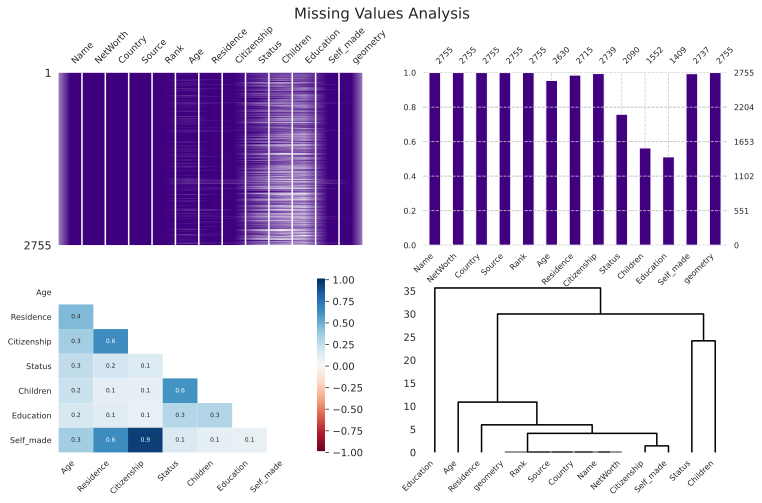

In [9]:
fig, ax = plt.subplots(2,2,figsize=(12,7))
axs = np.ravel(ax)
msno.matrix(data,  fontsize=9, color=(0.25,0,0.5),ax=axs[0]);
msno.bar(data, fontsize=8, color=(0.25,0,0.5), ax=axs[1]);
msno.heatmap(data,fontsize=8,ax=axs[2]);
msno.dendrogram(data,fontsize=8,ax=axs[3], orientation='top')

fig.suptitle('Missing Values Analysis', y=1.01, fontsize=15);
#plt.tight_layout()

Name, NetWorth, Country, Source, Rank, and Geometry show no missing values in their series, while Age, Residence, Citizenship, and Self-Made are almost complete. The remaining three series, Education, Children and Status, have significant gaps in their records. In general, the missing values have a low correlation among themselves, save four exceptions. For example, the missing values in Self-Made are almost coincident with those in Citizenship. At the same time, there is a mild positive correlation between the missing values in Residence vs Self-Made, Residence vs Citizenship, and Status vs Children. 

The significant amounts of missing values in Status, Children, and Education make these features poor candidates for obtaining an accurate understanding of the money-elites.

### 1.2 Source of Wealth: Inconsistent Records
The feature "Source" aims at capturing the main origin of the billionaires' accumulated wealth. However, Forbes had adopted an inconsistent approach in collecting these data. When the source of wealth is connected with a popular or well-known company, then the Company name is reported (i.e. Amazon, Microsoft, Google and so forth). In other instances, the economic sector where the billionaire business operates is reported (i.e., software, machinery, food and beverage, and so forth).

In [10]:
data.head(6)

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry
0,Jeff Bezos,177.0,United States,Amazon,1,57.0,"Seattle, Washington",United States,In Relationship,4.0,"Bachelor of Arts/Science, Princeton University",True,POINT (-122.3300624 47.6038321)
1,Elon Musk,151.0,United States,"Tesla, SpaceX",2,49.0,"Austin, Texas",United States,In Relationship,7.0,"Bachelor of Arts/Science, University of Pennsy...",True,POINT (-97.74369950000001 30.2711286)
2,Bernard Arnault & family,150.0,France,LVMH,3,72.0,"Paris, France",France,Married,5.0,"Bachelor of Arts/Science, Ecole Polytechnique ...",False,POINT (2.3514616 48.8566969)
3,Bill Gates,124.0,United States,Microsoft,4,65.0,"Medina, Washington",United States,Divorced,3.0,"Drop Out, Harvard University",True,POINT (-122.2264453 47.620548)
4,Mark Zuckerberg,97.0,United States,Facebook,5,36.0,"Palo Alto, California",United States,Married,2.0,"Drop Out, Harvard University",True,POINT (-122.1598465 37.4443293)
5,Warren Buffett,96.0,United States,Berkshire Hathaway,6,90.0,"Omaha, Nebraska",United States,"Widowed, Remarried",3.0,"Master of Science, Columbia University; Bachel...",True,POINT (-95.9383758 41.2587459)


For instance, Bill Gates' source of wealth is recorded as "Microsoft", while for Larry Ellison (founder of Oracle), the dataset mentions a generic "software". Jeff Bezos's source is Amazon, but e-commerce is the provenience of Jack Ma's wealth. This approach creates series of difficulties when aggregating the data. When billionaires are grouped by the "Source" as it appears in the original dataset, billionaires like Jeff Bezos or Jack Ma would be classified in two different buckets. However, they both operate in the e-commerce business. 

Therefore, the dataset was reviewed to standardize the "Source" entries. As a result, taking the first six wealthiest people in the world as an example, Amazon becomes e-commerce, Tesla is replaced by "electric vehicles", LVMH by "luxury good", Microsoft by "software", Facebook by "social media" and Berkshire Hathaway by "finance".

This operation has been implemented in "Forbes-Billionaires-modified" dataset, [Link](https://www.kaggle.com/fabrizio78/forbes-billionaires-modified)

The new dataset is now uploaded:

In [11]:
data =  pd.read_csv('/kaggle/input/forbes-billionaires-modified/forbes_billionaires_geo_3.csv')
data.head(6)

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry
0,Jeff Bezos,177.0,United States,e-commerce,1,57.0,"Seattle, Washington",United States,In Relationship,4.0,"Bachelor of Arts/Science, Princeton University",True,POINT (-122.3300624 47.6038321)
1,Elon Musk,151.0,United States,electric vehicles,2,49.0,"Austin, Texas",United States,In Relationship,7.0,"Bachelor of Arts/Science, University of Pennsy...",True,POINT (-97.74369950000001 30.2711286)
2,Bernard Arnault & family,150.0,France,luxury goods,3,72.0,"Paris, France",France,Married,5.0,"Bachelor of Arts/Science, Ecole Polytechnique ...",False,POINT (2.3514616 48.8566969)
3,Bill Gates,124.0,United States,software,4,65.0,"Medina, Washington",United States,Divorced,3.0,"Drop Out, Harvard University",True,POINT (-122.2264453 47.620548)
4,Mark Zuckerberg,97.0,United States,social network,5,36.0,"Palo Alto, California",United States,Married,2.0,"Drop Out, Harvard University",True,POINT (-122.1598465 37.4443293)
5,Warren Buffett,96.0,United States,finance,6,90.0,"Omaha, Nebraska",United States,"Widowed, Remarried",3.0,"Master of Science, Columbia University; Bachel...",True,POINT (-95.9383758 41.2587459)


### 1.3 Geometry: Latitude and Longitude unpacking
Two variables describe Billionaires current location: Residence and Geometry. The "Residence" comes with 40 missing values, while "Geometry" seems to have no gaps. However, this interpretation is misleading since when an exact location is not available, "geometry" reports the mid-point of the Country. Despite that, the "Geometry" series is the easiest to use for data analysis. 
The information is stored in the format "POINT(Latitude Longitude)", with the two numbers separated by a space.  Therefore, two additional features, Longitude and Latitude, are created by unpacking this information out from "Geometry" using the following lines of code:

In [12]:
data['Longitude'] = data['geometry'].apply(lambda x: float(x.split()[2].replace(')',''))+np.random.normal()/20)
data['Latitude'] = data['geometry'].apply(lambda x: float(x.split()[1].replace('(',''))+np.random.normal()/20)
data['Weight'] = data['NetWorth']/data['NetWorth'].max()

To avoid the precise overlapping of all the billionaires living in the same city, their locations are artificially scattered around by adding a small noise to the original coordinates. At the end of the process, the dataset comprises 14 features (the original "geometry" is dropped as redundant).

### 2. **First Analysis: Some Gossip**
Before analyzing more serious topics, I tackle the billionaires' dataset from a more frivolous perspective: how many children. This feature is not particularly relevant, considering that it covers approximately only 56% of the dataset. Nevertheless, since I know first-hand how hard it is to reconcile parenting and work, I am quite interested in the topic. A simple histogram provides immediate visualization of the distribution in the number of children:

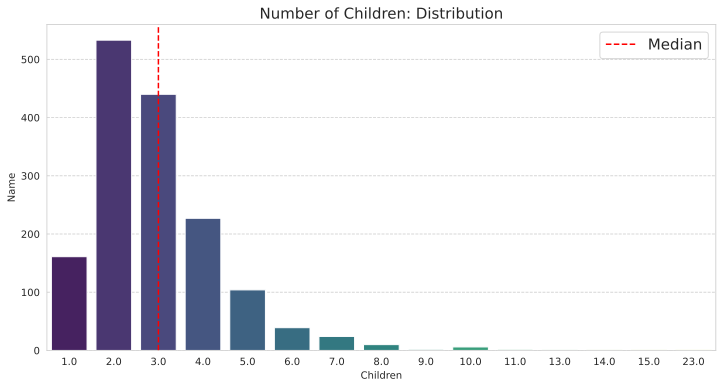

In [13]:
data_children = data.groupby(['Children']).agg({'Name':'count'}).reset_index()

fig, ax = plt.subplots(figsize=(12,6))

ax = sns.barplot(x="Children", y="Name", data=data_children,palette = 'viridis')
ax.set_title('Number of Children: Distribution', fontsize=15);
ax.axvline(x=data.Children.median()-1, ymin=0, ymax=550, color='red', linestyle='--', label='Median')

ax.legend(fontsize=15);

The billionaires' median number of children is three, with the average only slightly lower, 2.98. The most frequent number of children is two, opted in 533 out of 1'552 cases, followed by 3, 440 cases, and 4, 227 cases. It is interesting to note that none of the billionaires for which the data are available reports zero children.  This consideration suggests that the frequent "N/A" record for this feature is a mixed bag of genuinely missing values and zeros. For instance, for the youngest billionaire, Kevin David Lehmann, 18yo, the dataset reports"NA" under the number of children, but realistically it is a zero. At the other end of the range, a billionaire has 23 children. After filtering the dataset, it turns out that this large family belongs to Roman Avdeev, a 53 yo Russian billionaire. According to the Wikipedia webpage dedicated to him ([link](https://medium.com/r/?url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FRoman_Avdeev)), he is an active philanthropist supporting orphans, and 19 of his 23 children are adopted.

In [14]:
data[data['Children']==23]

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry,Longitude,Latitude,Weight
1752,Roman Avdeev,1.8,Russia,"banking, development",1750,53.0,"Moscow, Russia",Russia,Married,23.0,"Bachelor of Science in Engineering, Moscow Int...",True,POINT (37.6174943 55.7504461),55.749483,37.611048,0.010169


In [15]:
data[data['Age']==data['Age'].min()]

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry,Longitude,Latitude,Weight
940,Kevin David Lehmann,3.3,Germany,drugstores,925,18.0,NaN,Germany,NaN,NaN,NaN,False,POINT (10.4234469 51.0834196),51.059054,10.424411,0.018644


Before moving to the next paragraph, I want to investigate the significant amount of missing values in the "children". When grouped by countries, it turns out that the bulk of the gaps in the records belongs to billionaires with Chinese citizenship, 545 cases out of 1'223 missing values.

In [16]:
data_children_na = data[data['Children'].isna()==True]
data_children_na.groupby('Country')['Name'].agg('count').sort_values(ascending=False)[:10]

Country
China             545
United States     191
Germany            75
Canada             35
Hong Kong          28
United Kingdom     27
Japan              26
Brazil             26
Sweden             23
Italy              21
Name: Name, dtype: int64

Considering that Chinese billionaires in the dataset are 626, it means that 87% of the data are missing for this specific group. Therefore, the statistics presented so far on the number of children are not representative of this subset. Forbes provides no clear reason for this concentration of missing values in a single country. As a general consideration, since the one-child policy lasted for about 4 decades, the number of children can be a sensitive topic even for billionaires in China.

### 3. **Billionaires: Where to find them**
This article and the analysis aim to provide an in-depth representation of how billionaires and their wealth are distributed across countries and how their economic power is distributed among themselves and according to geography, age, and source. Particular attention is dedicated to comparing these metrics between the two world economic powerhouses: the United States of America and China.
3.1 Where are they? How much they have?
When measured by the sheer number of total billionaires, the United States and China dwarf the rest of the world. Alone they totalize about 49% of the people in the dataset and more than 50% of the total wealth. The United States still have a hedge in comparison to the runner-up. There are 724 billionaires in the USA against the 626 from China.

In [17]:
data.fillna(value=np.nan, inplace=True)
data[['Age','Children']] = data[['Age','Children']].astype('Int64')

## group data by country on total net worth and count of billionaire
country_grp=data.groupby(by='Country').agg({'Name':'count','NetWorth':'sum'}).reset_index()

## group data by country on total net worth and count of billionaire
country_grp_median=data.groupby(by='Country').agg({'Name':'count','NetWorth':'median'}).reset_index()
country_grp_median.rename({'Name':'Tot Billionares','NetWorth':'Median Net Worth'},axis=1,inplace=True)
country_grp_median.sort_values(by='Median Net Worth',ascending=False,inplace=True)

country_grp.rename({'Name':'Tot Billionares','NetWorth':'Aggregate Net Worth'},axis=1,inplace=True)
country_grp['% Total Billionares']=round(country_grp['Tot Billionares']/sum(country_grp['Tot Billionares'])*100,2)
country_grp['% Total Wealth'] =round(country_grp['Aggregate Net Worth']/sum(country_grp['Aggregate Net Worth'])*100,2)
country_grp_tot_bil = country_grp.sort_values(by='Tot Billionares',ascending=False,inplace=False)
country_grp.sort_values(by='Aggregate Net Worth',ascending=False,inplace=True)
country_grp.reset_index(drop=True,inplace=True)
country_grp['Aggregate Net Worth']=round(country_grp['Aggregate Net Worth'],2)

country_grp.head(10)

,Country,Tot Billionares,Aggregate Net Worth,% Total Billionares,% Total Wealth
0,United States,724,4398.4,26.28,33.62
1,China,626,2531.9,22.72,19.35
2,Germany,136,625.5,4.94,4.78
3,India,140,596.4,5.08,4.56
4,Russia,118,586.0,4.28,4.48
5,France,42,512.2,1.52,3.91
6,Hong Kong,71,448.2,2.58,3.43
7,Canada,64,231.1,2.32,1.77
8,Japan,49,225.4,1.78,1.72
9,United Kingdom,56,213.9,2.03,1.63


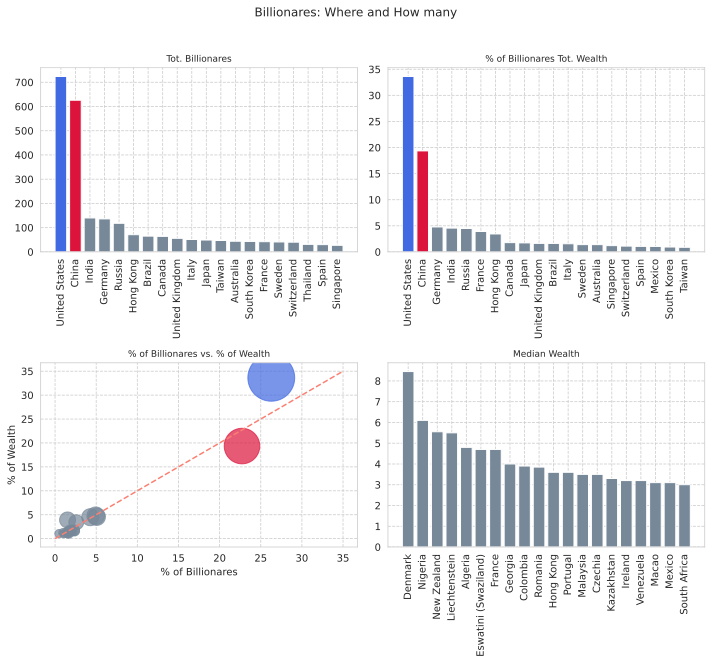

In [18]:
colors = ['lightslategray',] * 20
colors[0] = 'royalblue'
colors[1] = 'crimson'

fig, ax = plt.subplots(2,2,figsize=(10,9))

axs=np.ravel(ax)

axs[0].bar(x=country_grp_tot_bil['Country'][:20],height=country_grp_tot_bil['Tot Billionares'][:20],color=colors);
axs[0].tick_params(axis='x', labelrotation=90)
axs[0].set_title('Tot. Billionares', fontsize=9)
axs[1].bar(x=country_grp['Country'][:20],height=country_grp['% Total Wealth'][:20],color=colors);
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].set_title('% of Billionares Tot. Wealth', fontsize=9)
axs[2].scatter(x=country_grp['% Total Billionares'][:20],y=country_grp['% Total Wealth'][:20],color=colors,s=country_grp['Aggregate Net Worth'][:20]/2, alpha=0.7);
axs[2].plot([0,35],[0,35], color='salmon', linestyle='--')
axs[2].set_xlabel("% of Billionares")
axs[2].set_ylabel("% of Wealth")
axs[2].set_title('% of Billionares vs. % of Wealth', fontsize=9)
axs[3].bar(x=country_grp_median['Country'][:20],height=country_grp_median['Median Net Worth'][:20],color='lightslategray');
axs[3].tick_params(axis='x', labelrotation=90)
axs[3].set_title('Median Wealth',  fontsize=9)

fig.suptitle('Billionares: Where and How many', y=1.02, fontsize=12)
plt.tight_layout()

The gap is wider when the total wealth of these individuals is considered. In the United States, the billionaires piled up an aggregate wealth of $4'398.4billions against the $2'532bilions in China. Thus, the average billionaire in the United States is richer than his counterpart in China. This is highlighted by the left graph on the right, which compares the share (in percentage) of billionaires of each country against the share of the total wealth of this group. However, neither the United States nor China appears in the top 20 positions in terms of billionaires' median wealth. Here the ranking is dominated by European, African and Central Asian countries (see the bottom-right graph above ).

A similar analysis can be performed, replacing the countries with the city where the billionaires live.

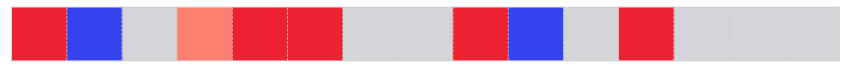

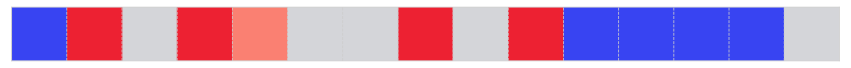

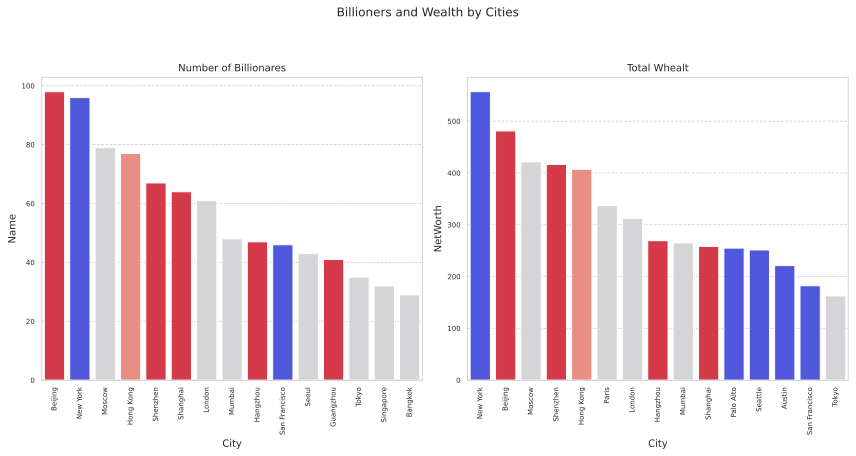

In [19]:
# Groupby by city:
city_df = data.groupby(by='Residence').agg({'Name':'count','NetWorth':'sum'}).reset_index()
city_df['City'] =city_df['Residence'].apply(lambda x: x.split(', ')[0])
city_df.drop('Residence', inplace=True, axis=1)

# Create color series
custom_colors_1 = ['#ed2132','#3844f2','#d4d5d9','salmon','#ed2132','#ed2132','#d4d5d9','#d4d5d9','#ed2132','#3844f2','#d4d5d9','#ed2132','#d4d5d9','#d4d5d9','#d4d5d9']
sns.palplot(sns.color_palette(custom_colors_1));

custom_colors_2 = ['#3844f2','#ed2132','#d4d5d9','#ed2132','salmon','#d4d5d9','#d4d5d9','#ed2132','#d4d5d9','#ed2132','#3844f2','#3844f2','#3844f2','#3844f2','#d4d5d9']
sns.palplot(sns.color_palette(custom_colors_2));

fig, axs = plt.subplots(1,2,figsize=(12,6))
city_df.sort_values(by='Name',ascending=False,inplace=True)
sns.barplot(x='City',y='Name',data = city_df.iloc[:15,:], palette =custom_colors_1, ax=axs[0]);
axs[0].tick_params(axis='x', labelrotation=90, labelsize=7)
axs[0].tick_params(axis='y', labelsize=7)
axs[0].set_title('Number of Billionares', fontsize=10)

city_df.sort_values(by='NetWorth',ascending=False,inplace=True)
sns.barplot(x='City',y='NetWorth',data = city_df.iloc[:15,:],palette=custom_colors_2, ax=axs[1]);
axs[1].tick_params(axis='x', labelsize=7, labelrotation=90)
axs[1].tick_params(axis='y', labelsize=7)
axs[1].set_title('Total Whealt',fontsize=10)
plt.suptitle('Billioners and Wealth by Cities', fontsize=12, y=1.05)

plt.tight_layout()

In terms of cities and the number of billionaires living within, Chinese ultra-rich people cluster together in a number of few cities. Beijing took over the role of the city with the highest number of billionaires, and China accounts for 5 (6 if Hong Kong is included) out of the 15 cities with the highest concentration of nabobs. The United States are in this ranking with only two names, New York and San Francisco. The picture is more even when the total wealth held by billionaires is considered. Reflecting the fact that US billionaires are on average richer, New York is still the city with the highest concentration of wealth while Beijing is now the runner-up. Within the first 15 positions, 5 cities are located in the USA and 4 (5 with HK) in China.  

Before looking into the details of the two biggest economies, the worldwide distribution of billionaires is analyzed. This is rendered by a heatmap on the top of a world map in the following graph:

In [20]:
# Prepare the relevant data:
list_coord = data[['Longitude','Latitude']].values
list_coord_weight = data[['Longitude','Latitude','Weight']].values

import plotly.express as px
fig = px.density_mapbox(data, lat='Longitude', lon='Latitude',radius=10,
                        center=dict(lat=20, lon=7), zoom=1.5,  hover_name='Name',
                        mapbox_style="carto-positron",color_continuous_scale='sunset', width=1550, height=1000, ) #, z='NetWorth'

fig.show()

From the map, three main clusters can be identified:
* The **US Cluster**, running from the east coast to the Hawaiian archipelago (the bright dot in the middle of the Pacific Ocean). It also encompasses the southern tip of Canada, thanks to the contributions of Ottawa and Toronto. 
* The **European Cluster**, covering an area that goes from the south of Spain to Stockholm and from the North of Italy to the British Islands.
* The third main cluster is concentrated in the **Far East**, hinging around the eastern part of China and including other countries such as South Korea and Japan.

In addition to these three key clusters, several secondary clusters can be identified, such as the Indian or the South America cluster (coastal area between the south of Brazil and north of Argentina).

### 4. **The Clash of Titans: the USA vs China**
### 4.1 Geography
As already highlighted, the United States and China together represent the lion share in the total number of billionaires. Therefore, it is natural to make a direct comparison between the two heavyweights in their category. As a first step, the billionaires of the two countries are plotted on a map. The dots represent their locations, and the dots' sizes their wealth. As noted above, Chinese billionaires are slightly poorer if compared to their US counterparts. This aspect is confirmed by the visually smaller sizes of the dots on the Chinese map. Moreover, the rolling-in-money persons are mostly concentrated in the east part of the country, close to the coast in the area, in an arch stretching from Beijing in the North to Hong Kong in the South. The dots then become more and more sporadic as we move west or north.

In [21]:
# Extract the Chinese Billionaires Data:
target = 'China'
China_bill_df = data.query('Country == @target')
list_coord_China = China_bill_df[['Name','NetWorth','Longitude','Latitude']].values

# Plot with Plotly:
import plotly.express as px

fig = px.scatter_mapbox(China_bill_df, lat="Longitude", lon="Latitude", color="NetWorth", size="NetWorth",
                  color_continuous_scale=px.colors.sequential.Sunsetdark_r, size_max=25, zoom=3.7, hover_name='Name',
                  mapbox_style="open-street-map", width=1500,height=800, opacity=0.7, range_color=[1,180], center={'lat':34.56462451406082, 'lon':105.70152050931392})
fig.show()

Additionally, within the high concentration area, three main clusters are located around Beijing, Shanghai, and the Pearl River Delta Area. The map can be navigated by zooming in and out, and by clicking on the dots, the details of the corresponding billionaire pop out. 

Looking at the five richest persons in China, at the top, there is Zhong Shanshan (Usd68.9B). His name might not be very familiar outside China. Still, if you ever visited the country, you should also have noticed the white-red labelled bottle of water sold anywhere, which are the backbone of his beverage industry empire (and the water is actually good).

In [22]:
China_bill_df.head(5)

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry,Longitude,Latitude,Weight
12,Zhong Shanshan,68.9,China,"beverages, pharmaceutical",13,66,"Hangzhou, China",China,NaN,<NA>,NaN,True,POINT (120.2052342 30.2489634),30.249890,120.156710,0.389266
14,Ma Huateng,65.8,China,internet media,15,49,"Shenzhen, China",China,Married,<NA>,"Bachelor of Arts/Science, Shenzhen University",True,POINT (114.0543297 22.555454),22.527186,114.040481,0.371751
20,Colin Zheng Huang,55.3,China,e-commerce,21,41,"Shanghai, China",China,NaN,<NA>,"Master, University of Wisconsin Madison; Bache...",True,POINT (121.4692071 31.2322758),31.287078,121.608216,0.312429
25,Jack Ma,48.4,China,e-commerce,26,56,"Hangzhou, China",China,Married,<NA>,"Bachelor of Arts/Science, Hangzhou Teacher's I...",True,POINT (120.2052342 30.2489634),30.280031,120.246899,0.273446
34,Wang Wei,39.0,China,package delivery,35,50,"Shenzhen, China",China,NaN,<NA>,NaN,True,POINT (114.0543297 22.555454),22.566565,114.181489,0.220339


Moving down from the top, there are more familiar names related to the internet and e-commerce, such as Ma Huateng (Tencent), Colin Zheng Huang (Pinduoduo), and Jack Ma (Alibaba). Finally, at the fifth place, there is Wang Wei, owner of the delivery service and logistics company "SF Express".


Moving to the other side of the Pacific Ocean, in the United States, two things strike the observer at first sight. First, the dots are significantly bigger and brighter (meaning richer billionaires), and they are more evenly distributed across the country. Although some areas are whiter than others, it is hard to identify some billionaire-free regions. Second, there are probably six main clusters in the country: the north and south (or California) Pacific clusters, the central cluster, one around the Great Lakes area, another in the North-East and eventually one located in Florida.

In [23]:
# Extract the US Billionaires Data:
target = 'United States'
US_bill_df = data.query('Country == @target')
list_coord_US = US_bill_df[['Name','NetWorth','Longitude','Latitude']].values

# Plot with plotly
fig = px.scatter_mapbox(US_bill_df, lat="Longitude", lon="Latitude", color="NetWorth", size="NetWorth",
                  color_continuous_scale=px.colors.sequential.Sunsetdark_r, size_max=50, zoom=3.2, hover_name='Name',
                  mapbox_style="open-street-map", width=1500,height=800, opacity=0.7, range_color=[1,180], center={'lon':-115.0,'lat':35.0})
fig.show()

As for the names behind the dots, the 5 richest persons of the country (and the world) are reported in the next table. All these names and their businesses are very popular. Therefore I will provide them with no comments.

In [24]:
US_bill_df.head(5)

,Name,NetWorth,Country,Source,Rank,Age,Residence,Citizenship,Status,Children,Education,Self_made,geometry,Longitude,Latitude,Weight
0,Jeff Bezos,177.0,United States,e-commerce,1,57,"Seattle, Washington",United States,In Relationship,4,"Bachelor of Arts/Science, Princeton University",True,POINT (-122.3300624 47.6038321),47.635336,-122.348418,1.000000
1,Elon Musk,151.0,United States,electric vehicles,2,49,"Austin, Texas",United States,In Relationship,7,"Bachelor of Arts/Science, University of Pennsy...",True,POINT (-97.74369950000001 30.2711286),30.212459,-97.721310,0.853107
3,Bill Gates,124.0,United States,software,4,65,"Medina, Washington",United States,Divorced,3,"Drop Out, Harvard University",True,POINT (-122.2264453 47.620548),47.582798,-122.218544,0.700565
4,Mark Zuckerberg,97.0,United States,social network,5,36,"Palo Alto, California",United States,Married,2,"Drop Out, Harvard University",True,POINT (-122.1598465 37.4443293),37.387962,-122.126954,0.548023
5,Warren Buffett,96.0,United States,finance,6,90,"Omaha, Nebraska",United States,"Widowed, Remarried",3,"Master of Science, Columbia University; Bachel...",True,POINT (-95.9383758 41.2587459),41.314045,-95.978997,0.542373


Although the two maps presented show that from a geographic standpoint, wealth is more uniformly distributed in the United States than in the PRC, they also seem to suggest that the opposite applies in terms of the concentration of wealth itself. In the USA, the presence of some huge dots among many tiny little ones indicates that few people have a bigger share of the total wealth than in China. Here the small dots are as common as in the United States, but no dot stands immediately out for its size. This intuition is confirmed by the Gini Coefficient calculated on the wealth distribution in China (0.50) and the United States (0.56). The next two graphs provided a representation of the wealth distribution among the billionaires' population.

In [25]:
import pandas_datareader as pdr
gdp_china = pdr.get_data_fred('MKTGDPCNA646NWDB', freq='q',start = '01/01/2010', end='31/03/2021')/1_000_000_000
gdp_us = pdr.get_data_fred('GDP', freq='q',start = '01/01/2010', end='31/03/2021')

new_df = data.groupby(['Country']).agg({'NetWorth':'sum'})

new_df.sort_values(by='NetWorth',ascending=False,inplace=True)
new_df = new_df.iloc[:2,:]
# Create tow new columns to accomodate the values
new_df['Share of GDP'] = np.nan
new_df['Gini'] = np.nan
# Create the total whealth to GDP and Gini valueas 
new_df.loc['United States','Share of GDP'] = new_df.loc['United States','NetWorth']/gdp_us['GDP'][-1]
new_df.loc['China','Share of GDP'] = new_df.loc['United States','NetWorth']/gdp_china['MKTGDPCNA646NWDB'][-1]

target='China'
china_bills = data.query('Country==@target')['NetWorth'].values
target='United States'
us_bills = data.query('Country==@target')['NetWorth'].values

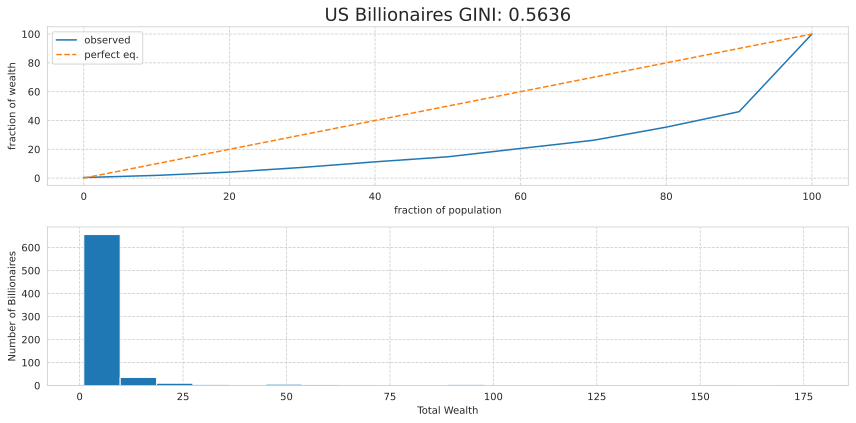

In [26]:
bins, result, us_gini_val = G(us_bills)
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("fraction of population")
plt.ylabel("fraction of wealth")
plt.title("US Billionaires GINI: %.4f" %(us_gini_val), fontsize=18)
plt.legend()
plt.subplot(2, 1, 2)
plt.hist(us_bills, bins=20)
plt.xlabel("Total Wealth")
plt.ylabel("Number of Billionaires")
plt.tight_layout()

plt.savefig('US_Gini.png', bbox_inches='tight')

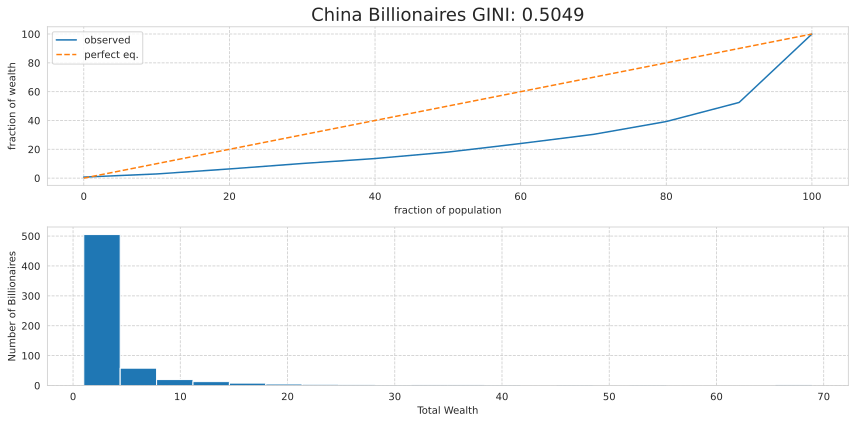

In [27]:
bins, result, china_gini_val = G(china_bills)
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("fraction of population")
plt.ylabel("fraction of wealth")
plt.title("China Billionaires GINI: %.4f" %(china_gini_val), fontsize=18)
plt.legend()
plt.subplot(2, 1, 2)
plt.hist(china_bills, bins=20)
plt.xlabel("Total Wealth")
plt.ylabel("Number of Billionaires")
plt.tight_layout()

plt.savefig('CH_Gini.png', bbox_inches='tight')

An additional metric to better appreciate the wealth accumulated by the ultra-rich persons is to measure it against the annual GDP produced in these two countries. Just to be clear: this comparison is intrinsically wrong since it compares a flow (GDP) against a stock (wealth). However, it is interesting to analyze how long these entire communities have to work to reproduce the total wealth owned by this little bunch of individual. By using the GDP data at the end of Q1–2021, the ratios are reported in the table below:

In [28]:
new_df.loc['United States','Gini'] = us_gini_val.round(3)
new_df.loc['China','Gini'] = china_gini_val.round(3)

new_df.round(3)

,NetWorth,Share of GDP,Gini
Country,,,
United States,4398.4,0.199,0.564
China,2531.9,0.308,0.505


Although relatively poorer, the ratios tell that Chinese billionaires command a higher share (31%) of wealth compared to the annual total incomes produced by their country, about 50% higher than in the United States (20%).

### **4.2 Age and Origin of Wealth**

The next aspect studied in this comparison between the two economic superpowers is the distribution of wealth in terms of age and its relationship with the main source from which it was originated. This analysis can provide some important insight into how the economies have evolved over time and the forces shaping their developments. History shows us that the waves of rising and declining sectors and industries have witnessed the creation of new fortunes and rising stars in the constellation of the wealthy elites. Moreover, money is a source of power since the dawn of times. By understanding where this power is concentrated from the age and economic standpoints, we can better comprehend how this power is wielded.

The first graph proposed aggregates the wealth within each country according to the age cohort. A first important piece of information emerges: the Chinese billionaires in their fifties are the richest group worldwide. Alone they represent about 50% of the total billionaires' wealth of their country, or 1.15 trillion of USD, and outstrip the runner-up group, US billionaires in the 70yo cohort, by a whooping 100billion, or 10% more. And this happens even though the US group came from a larger economy and the billionaire's pool of wealth is 80% bigger.

In [29]:
df_CONT = px.data.gapminder().query("year == 2007")
dict_cont = dict(df_CONT[['country','continent']].values)
country_grp_median['Continent'] = country_grp_median['Country'].map(dict_cont)

# Verify for missing values and replace:
list_missing_cont = list(country_grp_median[country_grp_median['Continent'].isna()==True]['Country'])
new_map = ['Europe','Africa','Europe','Asia','Europe','Asia','Asia','Europe','Asia','Europe','Europe','Europe','Asia','Europe','Asia','Europe','Europe']
new_dict_cont = dict(zip(list_missing_cont,new_map))

# Create and aggregate dictionary
z = {**dict_cont, **new_dict_cont}

country_grp_median['Continent'] = country_grp_median['Country'].map(z)

In [30]:
data_age_clean = data.dropna(subset=['Age'])

data_age_clean['age_group'] = data_age_clean.apply(lambda x: Age(x["Age"]), axis = 1)

## Map the Continent
data_age_clean['Continent'] = data_age_clean['Country'].map(z)

# Group dataset:
data_age_clean_grouped_sum=data_age_clean.groupby(by=['Country','Continent','age_group']).agg({'Name':'count','NetWorth':'sum'}).reset_index()
data_age_clean_grouped_sum.rename({'Name':'Tot Billionares','NetWorth':'Total Net Worth'},axis=1,inplace=True)

#Tree map representing most number of Billionaires
ax= px.treemap(data_age_clean_grouped_sum,path=["Continent",'Country','age_group'],width=1550, height=1100,values='Total Net Worth',color='Total Net Worth',title='Billionares: Wealth and Age',color_continuous_scale='RdBu',)
ax.show()

However, this analysis overlooks one important difference between the two countries. China liberalized its economy only in 1978 when it started its breakneck development. Therefore, also the process of private wealth accumulation has started only from that time on. Even those in their 40s at that point in time, nowadays they should still be alive. This consideration is important to read the next graphs from a proper perspective.

In [32]:
df_age = data.dropna(subset=['Age'])
# Define Age Group feature
df_age['age_group'] = df_age['Age'].apply(lambda x: Age(x))
# Create a sub-dataframe with US Data
target = 'United States'
df_age_US = df_age.query('Citizenship==@target')
# Create a sub-dataframe with Chinese Data
target = 'China'
df_age_CH = df_age.query('Citizenship==@target')
# Show the shape of the two datasets:
print('US data lenght: {}'.format(df_age_US.shape[0]))
print('China data lenght: {}'.format(df_age_CH.shape[0]))

US data lenght: 709
China data lenght: 588


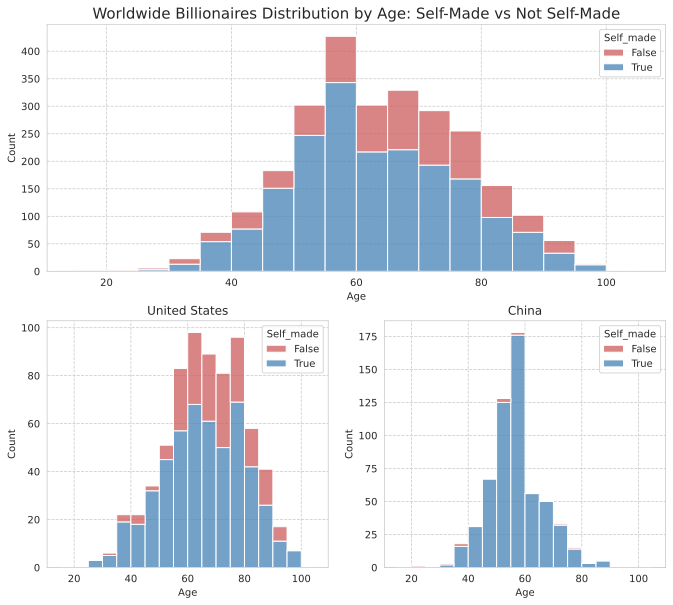

In [33]:
bins = list(range(15,110,5))

fig = plt.figure(constrained_layout=False, figsize=(20,10))

gs1 = fig.add_gridspec(nrows=4, ncols=4, left=0.05, right=0.48, wspace=0.5, hspace=0.5)

f8_ax1 = fig.add_subplot(gs1[:2, :])
sns.histplot(data=df_age, x='Age',stat= 'count',hue ='Self_made',bins=bins, palette=['indianred','steelblue'],multiple='stack', element='bars', ax=f8_ax1);
f8_ax1.set_title('Worldwide Billionaires Distribution by Age: Self-Made vs Not Self-Made', fontsize=15)
f8_ax1.tick_params(axis='x', labelsize=10)
f8_ax1.tick_params(axis='y', labelsize=10)

f8_ax2 = fig.add_subplot(gs1[2:, :2])
sns.histplot(data=df_age_US, x='Age',stat= 'count',hue ='Self_made',bins=bins, palette=['indianred','steelblue'],multiple='stack', element='bars', ax=f8_ax2);
f8_ax2.set_title('United States', fontsize=12)
f8_ax2.tick_params(axis='x', labelsize=10)
f8_ax2.tick_params(axis='y', labelsize=10)

f8_ax3 = fig.add_subplot(gs1[2:, 2:])
sns.histplot(data=df_age_CH, x='Age',stat= 'count',hue ='Self_made',bins=bins, palette=['indianred','steelblue'],multiple='stack', element='bars', ax=f8_ax3);
f8_ax3.set_title('China', fontsize=12)
f8_ax3.tick_params(axis='x', labelsize=10)
f8_ax3.tick_params(axis='y', labelsize=10)

plt.tight_layout()

In the histograms above, the billionaires belonging to each of the age's cohorts are also identified as Self Made or not. In the United States, there is always a significant portion of persons who have inherited their fortune in each age group. In the age bins from 55yo to 95yo, wealthy people by inheritance represents about 30% of each group. In China, on the contrary, for the reason explained above, almost all the billionaires belong to the first generation/self-made group. To prevent the analysis from being affected by this difference in the two subsets, only self-made billionaires in both countries are considered. Unfortunately, a comparison between "second-generation" billionaires is impossible since this group is too small in China. 

Based on these considerations, the following graphs analyse the distribution of wealth according to age and source, first in China and then in the USA. In the graphs, each square represents an economic sector, with the colour depending on the amount of wealth accumulated, while the size is determined by the total number of Billionaires.

In [34]:
data_age_clean_ch = data_age_clean.query('Country=="China"&Self_made==True') 

data_age_clean_ch_grouped_sum=data_age_clean_ch.groupby(by=['age_group','Source']).agg({'Name':'count','NetWorth':'sum'}).reset_index()
data_age_clean_ch_grouped_sum.rename({'Name':'Tot Billionares','NetWorth':'Total Net Worth'},axis=1,inplace=True)

#Tree map representing most number of Billionaires
ax= px.treemap(data_age_clean_ch_grouped_sum,path=["age_group",'Source'],width=1500, height=1100,values='Tot Billionares',color='Total Net Worth',title='First Generation Billionaires in China: Treemap Representation by Age and Source',color_continuous_scale='RdBu')
ax.show()

When analyzing the Chinese billionaires three map representation, two main elements emerge. The first is the unbalanced dominance of the age group of billionaires in their 50s. In China, this group alone represents about 50% of all the wealth accumulated by billionaires, and it is the richest age group worldwide by far. The second feature emerging is related to the dramatic shift in the sectors from which the billionaires derived their fortunes between the age groups in their 40s and 30s and those above. Economic activities related to real estate and pharmaceutical generated the greatest number of billionaires and concentration of wealth in all the age cohorts above the 40yo. In general, in these groups, the economic sector landscape is related to the old economy and manufacturing activities such as food&beverages, chemicals, automobile, apparel and so forth. However, as we enter into the 40yo cohort, the picture changes. This age group is made up of persons who were in their 20s at the turn of the century when the Internet took off and spread worldwide. This economic revolution is fully represented here. True, real estate and pharmaceutical are still on the list. However, they definitely moved to a secondary role. Internet-related services took the lead as billionaires churning out sectors. E-commerce billionaires in their 40s show the greatest concentration of wealth among all the age/sectors combinations. Other relevant sectors are Online Games, Software and Internet Media. The economic revolution is then definitely confirmed by the sector compositions of the next age cohort, the billionaires in their 30s. Here all the traditional economic sectors have disappeared. Moreover, new emerging forces shaping the economy can be identified. They are connected to the spreading application of Artificial Intelligence (AI) and new forms of mobility.  As a result, along with sectors as video streaming, e-commerce and social networks, new fortunes are now created in electric vehicles and health IT businesses. For instance, in a ranking dominated by man, the latter is represented by Gong Yingying, Founder and Chairwoman of Yidu Tech, a leading medical big data and AI company in China and worldwide.

In [35]:
df_age_US_agg=df_age_US.query('Self_made==True').groupby(['age_group','Source'])['Name','NetWorth'].agg(Count_Names=('Name','count'),Total_whealth=('NetWorth','sum')).sort_values(by='Count_Names',ascending=False).reset_index()
df_age_US_agg.sample(5)

,age_group,Source,Count_Names,Total_whealth
103,70 years old,electronic trading,1,3.7
2,80 years old,real estate,11,52.8
124,80 years old,meat processing,1,3.0
274,60 years old,"supermarkets, investments",1,1.5
119,80 years old,plastics,1,2.0


In [37]:
#Tree map representing most number of Billionaires
ax= px.treemap(df_age_US_agg,path=["age_group",'Source'],width=1500, height=1100,values='Count_Names',color='Total_whealth',title='First Generation Billionaires in the USA: Treemap Representation by Age and Source',color_continuous_scale='RdBu',)
ax.show()

Moving to the USA, the first feature catching the observer's attention is the number of billionaires that own their fortune to activities related to the financial sector. The Forbes dataset differentiates the financial sector in many sub-categories such as investment, private equity,  hedge funds, money management, venture capital, finance, and several more. Together, these sectors have churned out the greatest number of billionaires in each age group, save among those in their 90s. However, in this case, I suspect that the difference is mostly due to a survival bias. On the contrary to what happened in China, the real estate sector played only a marginal role in creating new billionaires, save the cohort of the 80yo. In the USA, the shockwaves of the emerging new economy in the billionaires' composition starts to propagate only in the age groups younger than 80yo. The software sector, for instance, is an important creator of new billionaires among the 70s and in all the age groups until the 40yo group. It generated the highest accumulation of wealth among the billionaires in their 60s and 70s. As we move down the age groups, new sectors appear, such as e-commerce, cybersecurity,  social networks, online services and so forth. As in China, when the younger group are analyzed, new sources of wealth appear, and they are connected with the most recent economic development. Cryptocurrencies are an important billionaires incubator in the 40yo and 30yo age groups. Billionaires that created smartphone applications are specific to the age groups going from the 30s to the 20s. Forbes dataset is not particularly helpful to identify this group since it classifies phone apps in details, differentiating among application for dating, sport, trading, food delivery and so forth. On the contrary to the Chinese case, the USA manage to have a small group of billionaires in the 20yo group, with food delivery applications and sensor technologies as the source for their wealth. Despite the higher growth rate recorded in China, the USA still appears like the place where it is possible to get rich faster, as proved by the higher number of billionaires in their 30s and 20s.

### **Conclusions**

In this article, we took a deep dive into the Forbes dataset of the richest men on the hearth. First, a general overview of the dataset with its features and shortcoming has been provided. After a quick foray into the relationship between the number of children and wealth, billionaires' geographic distribution has been analyzed according to different dimension and clusters identified. Then China and the USA, the two main clusters, have been studied in greater details.  Again the geographic distribution within these countries as well as the wealth distribution among billionaires. After restricting the focus on the self-made billionaires, the relationship between Age and Origin of Wealth has been studied in details in both countries. Critical features within each of these two countries have been highlighted and studied along with their evolution in time according to the source of wealth.